# Music Genre Classification Project 
by Xena Maayah, James Potash, Rohan Poddar, Yijun Zhao, and Noame de-Boerdere

In [53]:
import numpy as np
import math
from scipy import sparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, make_scorer, brier_score_loss, log_loss


from sklearn.svm import LinearSVC, SVC
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import cross_val_score, KFold

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [44]:
music_data = pd.read_csv('../Data/features_3_sec.csv')
print("Shape:", music_data.shape)

Shape: (9990, 60)


In [4]:
music_data

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [5]:
music_data.rename(columns = {'label':'genre'}, inplace = True)

In [6]:
music_data = music_data.drop(columns=["filename"])

In [18]:
print(music_data["length"].unique())
music_data = music_data.drop(columns=["length"])
# Since there is only one value for segment length for all datapoints, we should drop the length feature from the music_data dataframe.

[66149]


In [23]:
ord_enc = OrdinalEncoder()
music_data["genre"] = ord_enc.fit_transform(music_data[["genre"]]).astype(int)

In [24]:
print(music_data["genre"].unique())

[0 1 2 3 4 5 6 7 8 9]


- For simplicity of use, we'll create a dictionary for our own use of mapping the music genres to numbers. 

In [25]:
categorical_genre = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop','reggae', 'rock']
ordinal_genre = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
mapping = {ordinal_genre[i]: categorical_genre[i] for i in range(len(ordinal_genre))}

In [26]:
mapping

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [29]:
numerical_features = [col for col in music_data.columns if music_data[col].dtype!='object']
corr = music_data[numerical_features].corr()
threshold = 0.9
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_col = [column for column in upper.columns if any(upper[column] >= threshold)]

In [30]:
upper.iloc[np.where(upper>=threshold)]

,rolloff_mean,rolloff_mean
spectral_centroid_mean,0.97436,0.97436
spectral_bandwidth_mean,0.95100,0.95100


Spectral_centroid_mean, spectral_bandwidth_mean are both highly correlated with rolloff_mean. We decided to drop rolloff_mean first.

In [31]:
music_data = music_data.drop(columns=["rolloff_mean"])
numerical_features = [col for col in music_data.columns if music_data[col].dtype!='object']
corr = music_data[numerical_features].corr()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_col = [column for column in upper.columns if any(upper[column] >= threshold)]
upper.iloc[np.where(upper>=threshold)]

""


In [32]:
music_data.groupby(['genre'])['genre'].count()

genre
0    1000
1     998
2     997
3     999
4     998
5    1000
6    1000
7    1000
8    1000
9     998
Name: genre, dtype: int64

The dataset is balanced so no need for stratification.

## Train, Test, Development Split

To start, we will be splitting our data set into a development set and a testing set using the 80:20 rule: 

In [33]:
X = music_data.drop('genre', axis=1)
y = music_data['genre']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Development X dataset shape:", X_dev.shape)
print("Test X dataset shape:", X_test.shape)
print("Development y dataset shape: ", y_dev.shape)
print("Test y dataset shape:", y_test.shape)

Development X dataset shape: (7992, 56)
Test X dataset shape: (1998, 56)
Development y dataset shape:  (7992,)
Test y dataset shape: (1998,)


Given this development set, we will split it into two sets: the training set and the validation set to be used for the development of our model: 

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)

print("Training X dataset shape:", X_train.shape)
print("Validation X dataset shape:", X_val.shape)
print("Training y dataset shape:", y_train.shape)
print("Validation y dataset shape:", y_val.shape)

Training X dataset shape: (6393, 56)
Validation X dataset shape: (1599, 56)
Training y dataset shape: (6393,)
Validation y dataset shape: (1599,)


## Training on the dataset 

Since we have done our data visualization and exploration, we can now start training different models on the dataset to train it to predict the the genre of music using 3 second features of the song.<br><br> 


### Linear Discrimination Analysis (LDA) Model

> First, we'll use a linear discrimination analysis (LDA) model to fit on the data for genre classification. This model would help us with dimensionality reduction, in comparison with PCA

In [59]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train) 

y_pred = lda.predict(X_test)  # Make predictions using the testing data

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6791791791791791


In [62]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[124   1  13   6   2  17  18   0  10  17]
 [  2 179   7   0   0  13   1   0   0   1]
 [ 13   0 117  12   0  11   5   4   4  20]
 [  4   5   8 112  13   1  13  12  12  19]
 [  4   2  10  11 146   0   9  17  16   3]
 [  8  16  13   5   1 138   1   3   3   4]
 [  2   0   1   4   2   0 174   0   0  21]
 [  3   2   8   9   8   2   0 145   3   0]
 [  9   2  15  10  14   4   5   2 139  11]
 [ 15   1  18  32   2  10  21   7   8  83]]


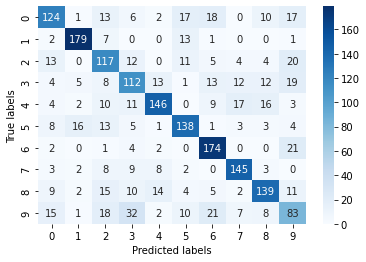

In [63]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

We can now see the classification report of the LDA model on for the ten differnt classes for the genre.

In [58]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.60      0.63       208
           1       0.86      0.88      0.87       203
           2       0.56      0.63      0.59       186
           3       0.56      0.56      0.56       199
           4       0.78      0.67      0.72       218
           5       0.70      0.72      0.71       192
           6       0.70      0.85      0.77       204
           7       0.76      0.81      0.78       180
           8       0.71      0.66      0.68       211
           9       0.46      0.42      0.44       197

    accuracy                           0.68      1998
   macro avg       0.68      0.68      0.68      1998
weighted avg       0.68      0.68      0.68      1998



Just as a reminder of what each number of the classes represents, we'll print the class dictionary: 

In [64]:
mapping

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

### Decision Tree Classifier

> Now, we'll train a regular decision tree classifier on the dataset

In [35]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train, np.ravel(y_train))

y_train_pred = dt.predict(X_train)
y_val_pred = dt.predict(X_val)

dev_accuracy = accuracy_score(y_train, y_train_pred)
dev_f1 = f1_score(y_train, y_train_pred, average=None)
test_acc = accuracy_score(y_val, y_val_pred)
test_f1 = f1_score(y_val, y_val_pred, average=None)

print("Development accuracy:", dev_accuracy)
print("Development F1-score:", dev_f1)
print("Test accuracy:", test_acc)
print("Test F1-score:", test_f1)

Development accuracy: 0.999061473486626
Development F1-score: [1.         1.         1.         1.         1.         1.
 0.99538462 1.         1.         0.99533437]
Test accuracy: 0.6741713570981863
Test F1-score: [0.64686469 0.86725664 0.54205607 0.57060519 0.67986799 0.67752443
 0.8013468  0.73809524 0.63283582 0.58709677]


We can now visualize the decision tree with max depth 8: 

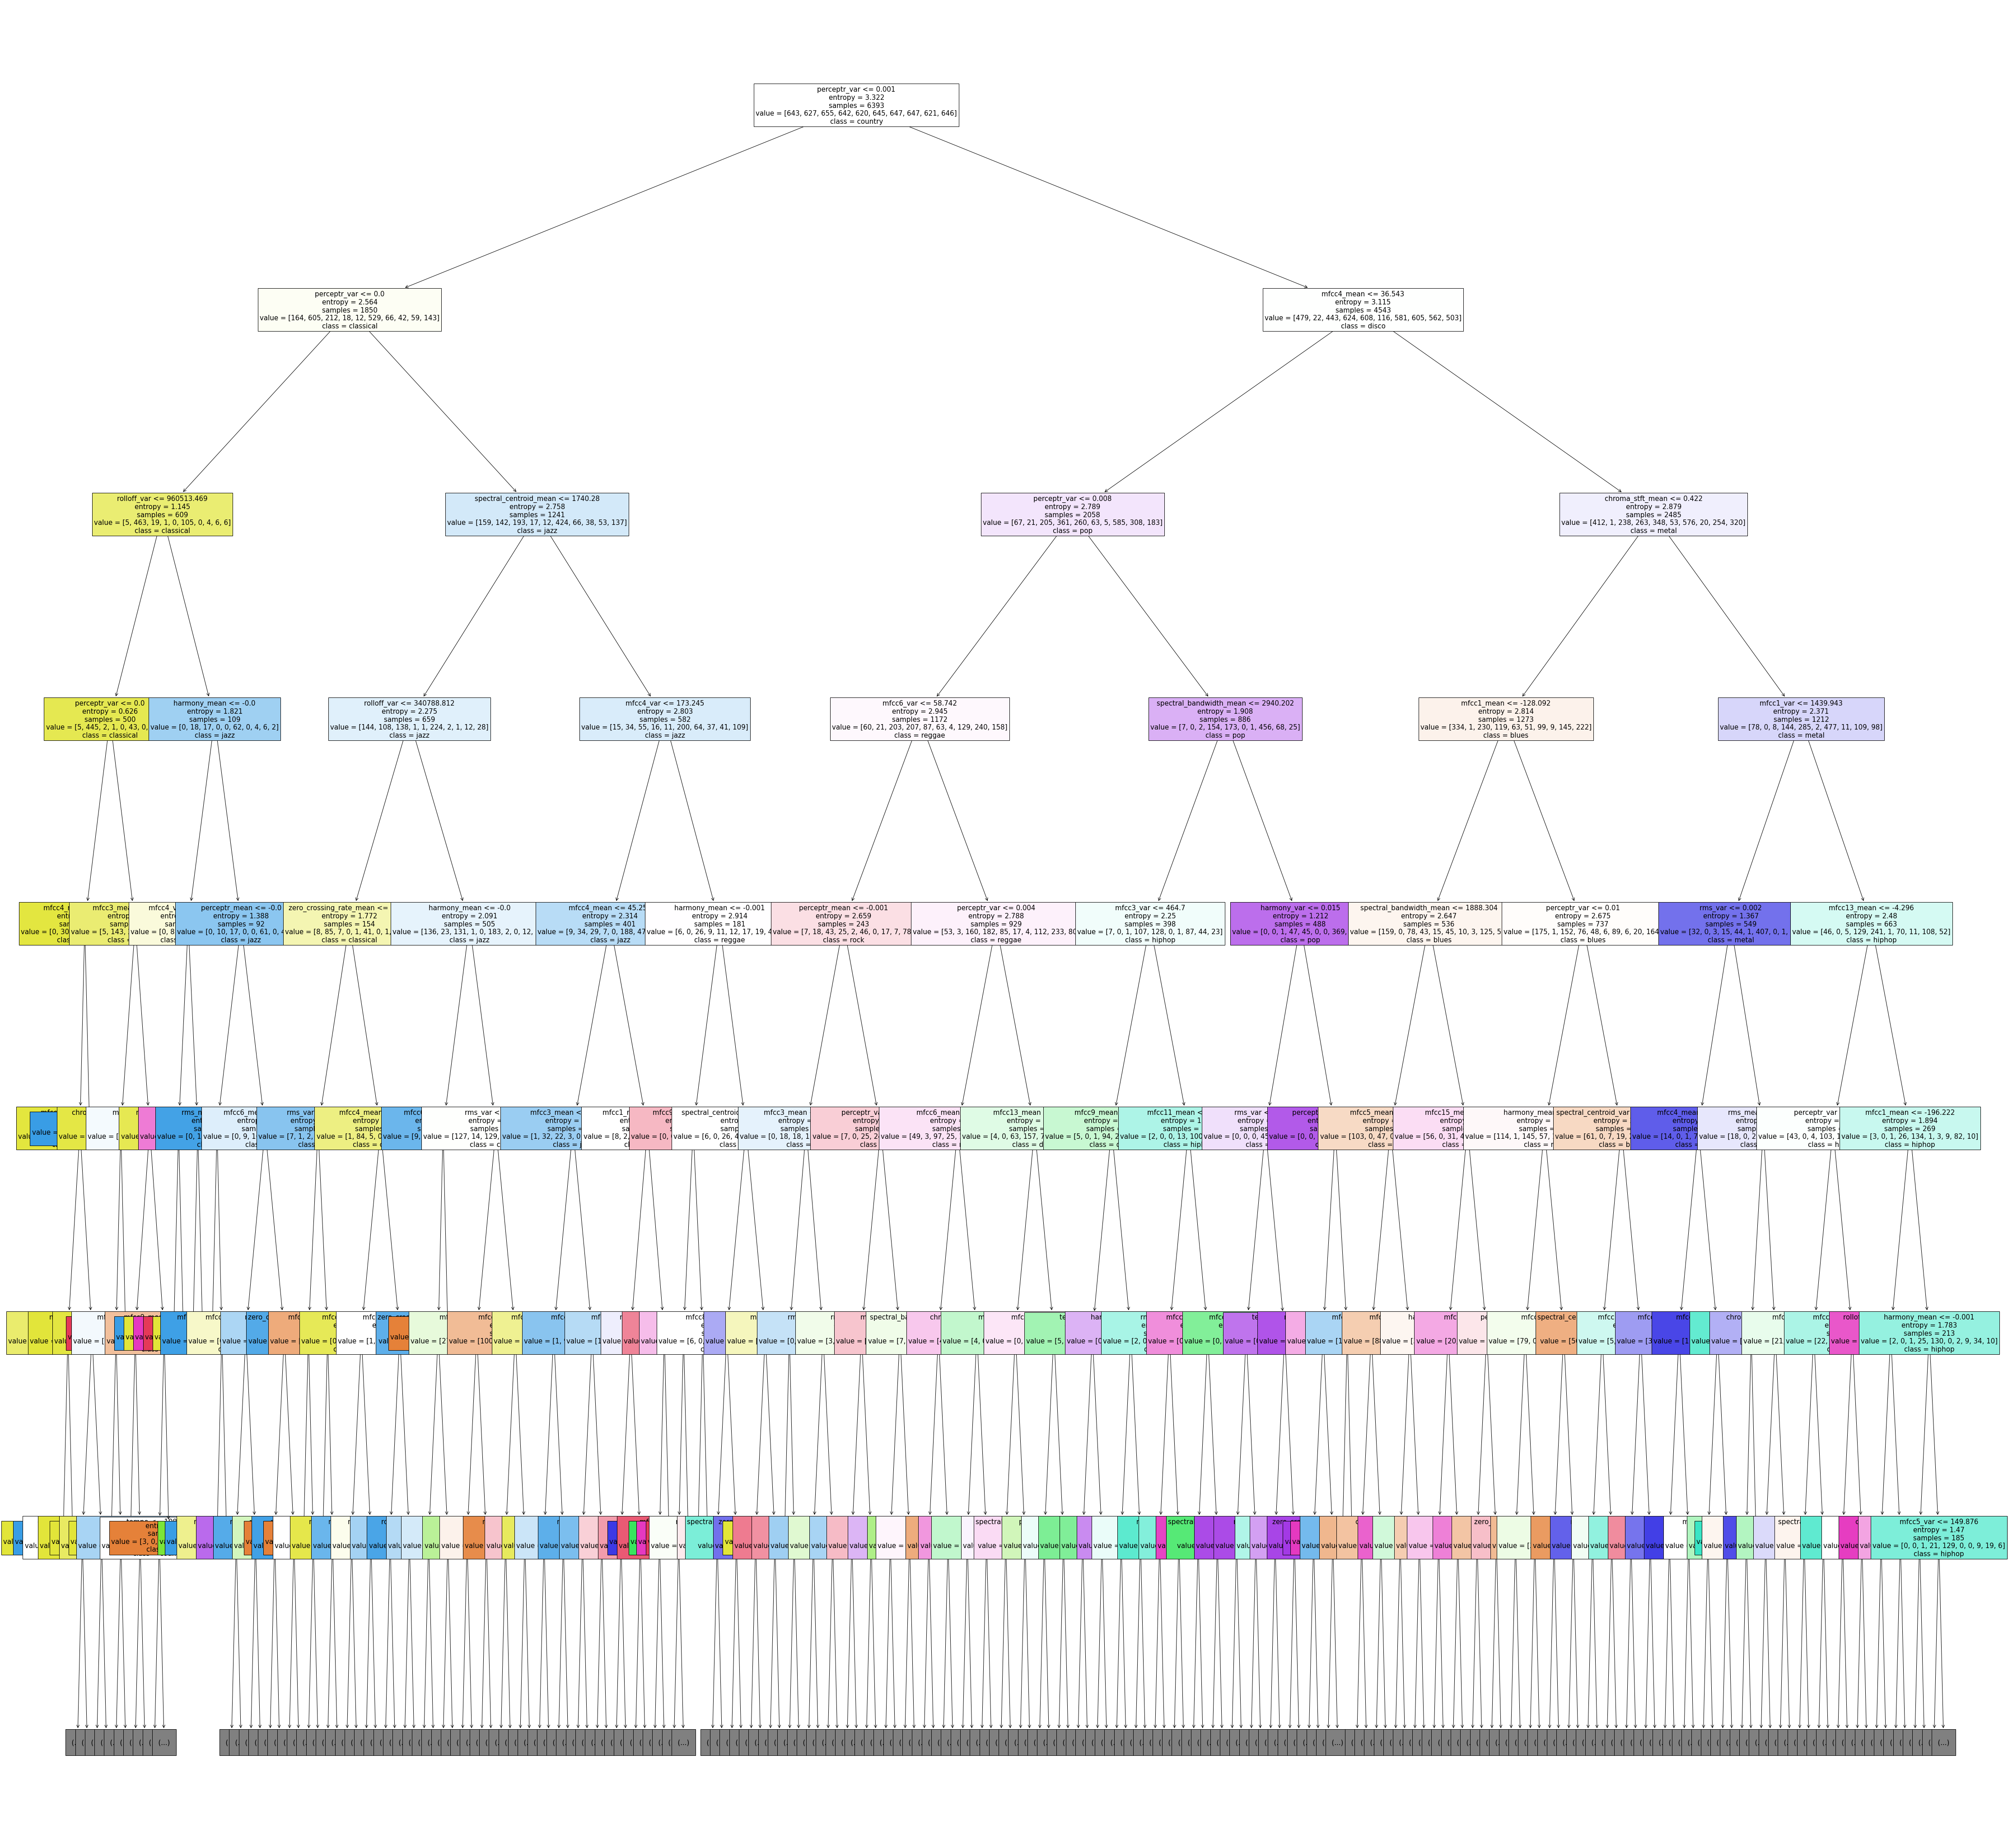

In [36]:
features = [col for col in music_data.columns]
plt.figure(figsize=(75,75))
plot_tree(dt, filled=True, feature_names=features, class_names=categorical_genre, max_depth=7, fontsize=15)
plt.show()

Now, we'll prune the decision tree classifier and find the optimal decision tree and its hyperparameters: 

In [37]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
ccp_alphas = [x for x in ccp_alphas if x >= 1e-5]

In [38]:
d_trees = []
scores = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    d_trees.append(dt)
    
    pred = dt.predict(X_val)
    score = accuracy_score(pred, y_val)
    scores.append(score)

best_score = max(scores)
best_alpha_idx = scores.index(best_score)
best_alpha = ccp_alphas[best_alpha_idx]
print("Best Score " + str(best_score))
print("Best Alpha " + str(best_alpha))

Best Score 0.6291432145090682
Best Alpha 0.00011808032256584833


Using the best alpha found from the best score, we will train an optimal decision tree classifier on the train/validation dataset.

In [39]:
dt_optimal = DecisionTreeClassifier(criterion='entropy', random_state=42, ccp_alpha = best_alpha)
dt_optimal.fit(X_train, np.ravel(y_train))

y_train_pred = dt_optimal.predict(X_train)
y_val_pred = dt_optimal.predict(X_val)

dev_accuracy = accuracy_score(y_train, y_train_pred)
dev_f1 = f1_score(y_train, y_train_pred, average=None)
test_acc = accuracy_score(y_val, y_val_pred)
test_f1 = f1_score(y_val, y_val_pred, average=None)

print("Development accuracy:", dev_accuracy)
print("Development F1-score:", dev_f1)
print("Test accuracy:", test_acc)
print("Test F1-score:", test_f1)

Development accuracy: 0.999061473486626
Development F1-score: [1.         1.         1.         1.         1.         1.
 0.99538462 1.         1.         0.99533437]
Test accuracy: 0.6741713570981863
Test F1-score: [0.64686469 0.86725664 0.54205607 0.57060519 0.67986799 0.67752443
 0.8013468  0.73809524 0.63283582 0.58709677]


Now, we'll train this optimal decision tree classifier on the original development set and test it on the original test set. 

In [40]:
dt_optimal = DecisionTreeClassifier(criterion='entropy', random_state=42, ccp_alpha = best_alpha)
dt_optimal.fit(X_dev, np.ravel(y_dev))

y_dev_pred = dt_optimal.predict(X_dev)
y_test_pred = dt_optimal.predict(X_test)

dev_accuracy = accuracy_score(y_dev, y_dev_pred)
dev_f1 = f1_score(y_dev, y_dev_pred, average=None)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average=None)

print("Development accuracy:", dev_accuracy)
print("Development F1-score:", dev_f1)
print("Test accuracy:", test_acc)
print("Test F1-score:", test_f1)

Development accuracy: 0.9992492492492493
Development F1-score: [1.         1.         1.         1.         1.         1.
 0.99624531 1.         1.         0.9962406 ]
Test accuracy: 0.6831831831831832
Test F1-score: [0.66493506 0.84910486 0.55526992 0.59431525 0.71748879 0.72773537
 0.79136691 0.75068493 0.63309353 0.54679803]


> To understand more about the model, we should find the importances of the features that contribute most in identifying the genre of a song. 

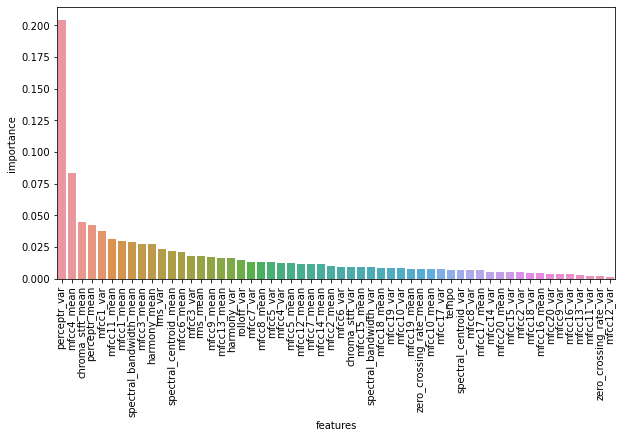

In [41]:
feat_imps = zip(features, dt_optimal.feature_importances_)

plt.figure(figsize=(10,5))
feats, imps = zip(*(sorted(list(filter(lambda x:x[1]!=0, feat_imps)),
                                      key=lambda x:x[1],
                                      reverse=True)))
ax = sns.barplot(x=list(feats), y=list(imps))
ax.tick_params(axis='x', rotation=90)
plt.ylabel('importance')
plt.xlabel('features')
plt.show()

The three most importance features from this dataset are perceptr_var, mfcc4_mean, and chroma_stft_mean

### Gradient Boosted Tree Classifier

> Finally, we'll use a gradient boosted tree classifer to perform the genre classification task 

First, we'll use GridSearch to find the best values for the following hyperparameters: learning rate, msx depth, and max leaf nodes.

In [45]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'max_leaf_nodes': [10, 50, 100]
}

clf = HistGradientBoostingClassifier(random_state=42)
scoring = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(clf, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_dev, y_dev)

print("Best hyperparameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'max_leaf_nodes': 100}
Best mean cross-validation score: 0.9056516106761532


After finding the optimal combination of hyperparameter values, we'll train an optimal Gradient boosted tree classifier on the data.

In [46]:
optimal_HGB = HistGradientBoostingClassifier(random_state=42, learning_rate=0.2, max_depth = 7, max_leaf_nodes=100)
optimal_HGB.fit(X_dev, np.ravel(y_dev))

train_acc = optimal_HGB.score(X_dev, y_dev)
train_f1 = f1_score(y_dev, optimal_HGB.predict(X_dev), average='weighted')
test_acc = optimal_HGB.score(X_test, y_test)
test_f1 = f1_score(y_test, optimal_HGB.predict(X_test), average='weighted')

print(f"Training accuracy: {train_acc}")
print(f"Training F1 score: {train_f1}")
print(f"Test accuracy: {test_acc}")
print(f"Test F1 score: {test_f1}")

Training accuracy: 0.9992492492492493
Training F1 score: 0.9992492451280622
Test accuracy: 0.9264264264264265
Test F1 score: 0.9265618185491182


Now we'll calibrate the model by finding the logarithmic loss, since we're dealing with multiple classes,  of the HistGradientBoosting model on the test dataset.

In [51]:
y_pred = optimal_HGB.predict_proba(X_test)
logloss = log_loss(y_test, y_pred)
print("Logarithmic loss:", logloss)

Logarithmic loss: 0.27339069836871005
